# Модель сегментации объектов ландшафта на данных АФС

## Содержание
* [Постановка задачи](#Постановка-задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Выбор гиперпараметров](#Выбор-гиперпараметров)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Оценка модели](#Оценка-модели)
* [Скорость работы](#Скорость-работы)
* [Критика](#Критика)
* [Краткое резюме](#Краткое-резюме)
* [Предложения по улучшению и развитию модели](#Предложения-по-улучшению-и-развитию-модели)

## Постановка задачи

#TODO Тут будет более подробная постановка задачи

Решается задача семантической сегментации: модель должна по снимку с БПЛА определить классы объектов на данном снимке. 

## Зависимости

При решении задачи используются следующие библиотеки и модули:

In [1]:
import sys
sys.path.append('../')

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import batchflow as bf

from batchflow import F,V,B,C
from batchflow import FilesIndex, Dataset
from batchflow.models.tf import UNet
from batchflow.research import Research, Results, Option
from batchflow.models.tf.losses import softmax_cross_entropy, dice

from aerial_batch import AerialBatch, get_origs, make_mask

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


## Датасет

Используется датасет [DeepGlobe Land Cover Classification](http://deepglobe.org/challenge.html), созданный для организации соревнования на конференции CVPR в 2018 году.
Датасет состоит из 803 снимков, полученных с помощью спутников комании DeepGlobe. 

Основные параметры снимков:
* размер снимка 2448х2448 пикселей
* разрешение 50 см / пиксель

Разметка (маска) представляет собой изображение того же размера, что и снимок. Каждому классу на снимке присовены определенные значения яркости пикселей в маске. Датасет содержит следующие классы:
* Неизвестно / облака
* Вода
* Лес
* Городская территория
* Пастбища
* Сельскохозяйственные земли
* Бесплодная земля

Процедура определения датасета:

In [2]:
ind = FilesIndex(path='../ignore/demo_sample/*.jpg')
ads = Dataset(ind, AerialBatch)

Загрузка изображения и маски:

In [3]:
batch = (ads.next_batch(1)
           .load(ind, fmt='image', components='images')
           .load(ind, fmt='mask', components='masks')
        )

Размер изображения:

In [4]:
batch.image_shape

(2448, 2448, 3)

Просмотр изображения и маски:

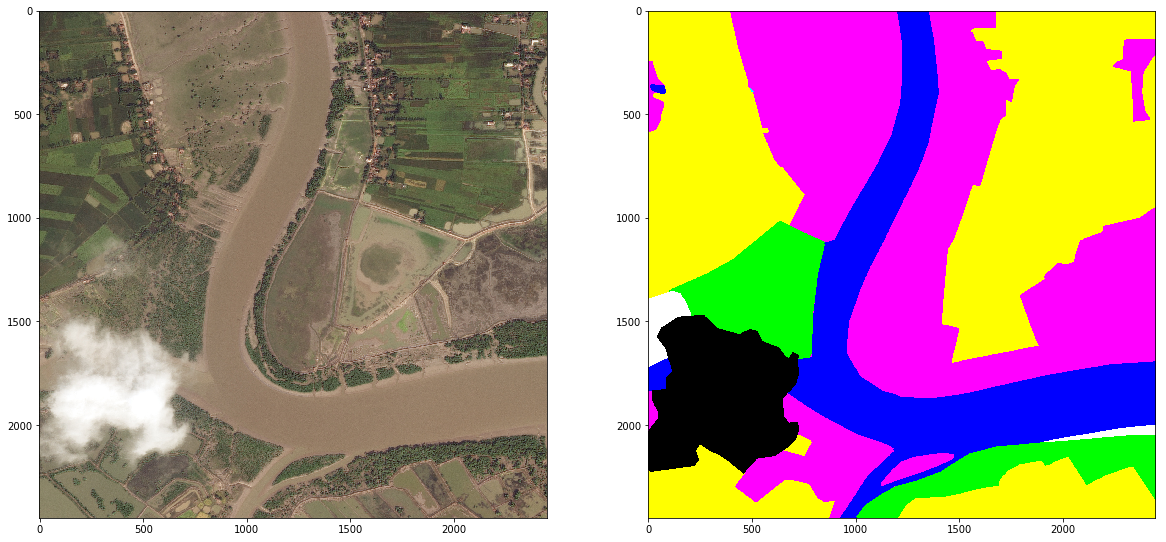

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(batch.images[0])
ax2.imshow(batch.masks[0])
plt.show()

Обучение на таких больших изображениях неэффективно, поэтому модель обучается на кропах - небольших кусочках изображения. Чтобы получить их, надо случайным образом вырезать часть изображения фиксированного размера:

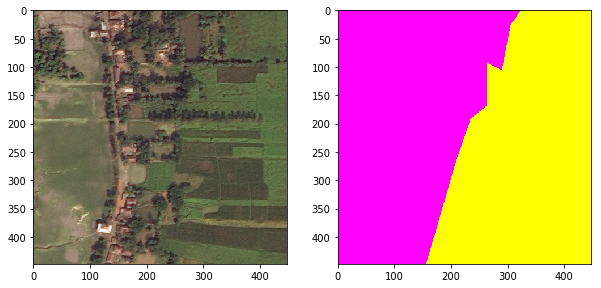

In [6]:
crop_shape = (448, 448)
origin = np.random.randint(0, 2000, size=(2))
batch_cropped = batch.deepcopy()
batch_cropped = (batch_cropped.crop(shape=crop_shape, origin=origin, src=['images'], dst='images')
                              .crop(shape=crop_shape, origin=origin, src=['masks'], dst='masks')
        )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(batch_cropped.images[0])
ax2.imshow(batch_cropped.masks[0])
plt.show()

Перед вырезкой кропа к изображению можно применить и другие преобразования, например, изменение размера или аугментации для повышения разнообразия данных. 

## Архитектура модели

Используется модель сверточной нейронной сети UNet, реализованная в библиотеке ```batchflow.models.tf```.

Конфигурация модели:
* Размер изображения на входе: (256, 256, 3)
* Размер изображения на выходе: (256, 256, 3)
* Количество блоков снижения / повышения размерности: 4
* Число фильтров в блоках: [64, 128, 256, 512]
* Количество классов для распознавания: 3 (Лес / Вода / Всё остальное)

Для обучения модели используется модифицированная функции потерь:

In [7]:
def ce_dice_loss(labels, logits, alpha=1, beta=0.5, *args, **kwargs):
    """
    Weighted  CE + DICE loss.
    """
    loss = alpha * softmax_cross_entropy(labels, logits) + beta * dice(labels, logits)
    return loss

Задание конфигурации модели:

In [8]:
model_config = {
    'initial_block/inputs': 'images',
    'inputs': dict(images={'shape': (256,256,3)}, 
                   masks={'name':'targets',
                          'shape': (256,256,3)}),
    'filters': [64, 128, 256, 512],
    'head/num_classes': 3,
    'loss': ce_dice_loss,
    'optimizer': 'Adam',
    'output': ['proba', 'class']
}

Задание обучающего датасета и разделение данных на обучающую и тестовую выборку в соотношении 80 / 20:

In [9]:
ind = FilesIndex(path='../ignore/deepglobe/train/*.jpg')
ads = Dataset(ind, AerialBatch)
ads.split(0.8)

## Обучение

Обучение проиcходит итерациями по батчам. Итерации состоит из:
* Загрузки нескольких изображений в батч
* Преобразования данных: аугментации, изменение размера, кроп
* Обработки батча нейронной сетью
* Обновления весов нейронной сети

Для обучения выбран оптимизатор Adam со стандартными параметрами:
* ```learning_rate``` = 0.001
* ```beta1``` = 0.9
* ```beta2``` = 0.999
* ```epsilon``` = 1e-08.

Функция потерь - взвешенная сумма cross-entropy и DICE.

Схема обхода датасета:
* Размер батча ```batch_size``` = 8
* Количество эпох обучения ```n_epochs``` = 100
* Размер кропа ```crop_size``` = (256, 256)

In [10]:
batch_size = 2
n_epochs = 100
crop_shape = (256, 256)

Описание пайплайна обучения:

In [21]:
train_template = (
    bf.Pipeline()
      .load(ind, fmt='image', components='images')
      .load(ind, fmt='mask', components='masks')
#     .augmentations!
      .resize(size=(1224, 1224), src=['images'], dst=['images'])
      .resize(size=(1224, 1224), src=['masks'], dst=['masks'])
      .apply_transform(get_origs, crop_shape, 0.8, src='masks', dst='origs')
      .crop(shape=crop_shape, src=['images', 'origs'], dst='images')
      .crop(shape=crop_shape, src=['masks', 'origs'], dst='masks')
      .to_array(src='images', dst='images')
      .to_array(src='masks', dst='masks')
      .apply_transform(make_mask, src='masks', dst='masks')
      .init_variable('loss', init_on_each_run=list)
      .init_model('dynamic', UNet, 'unet', model_config)
      .train_model('unet', images=B('images'), targets=B('masks'),
                      fetches='loss', save_to=V('loss'), mode='a')
).run(batch_size, shuffle=True, lazy=True)

train_pipeline = (train_template << ads.train)

Запуск обучения:

In [23]:
train_pipeline.run(batch_size, n_epochs=n_epochs, bar=True)

100%|█████████▉| 32099/32100 [6:24:05<00:00,  1.41it/s]


## Сходимость процесса обучения

График функции потерь в зависимости от числа итераций:

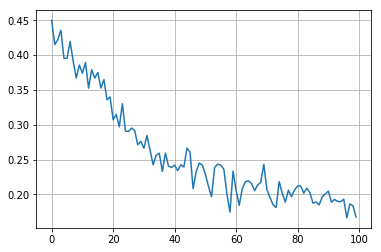

In [24]:
l = np.split(np.array(train_pipeline.get_variable('loss')), n_epochs)
f, ax = plt.subplots(1,1, figsize=(10, 5))
ax.plot(np.array(l).mean(-1))
ax.grid(True)

Сохранение модели:

In [13]:
MODEL_PATH = '../ignore/models/3c_0018300119'

In [11]:
# train_pipeline.save_model('unet', path=MODEL_PATH)

## Оценка модели

Качество модели определяется средним значением метрики IOU (intersection over union) по выборке из 161 кропа.

Конфигурация для загрузки обученной модели:

In [14]:
MODEL_PATH = '../ignore/models/3c_0018300119'

load_model_config = {
    'build': False,
    'load': {'path': MODEL_PATH}
}

Определение тестового пайплайна:

In [17]:
test_template = (
    bf.Pipeline()
      .load(ind, fmt='image', components='images')
      .load(ind, fmt='mask', components='masks')
#     .augmentations!
      .resize(size=(1224, 1224), src=['images'], dst=['images'])
      .resize(size=(1224, 1224), src=['masks'], dst=['masks'])
      .apply_transform(get_origs, crop_shape, 1.0, src='masks', dst='origs')
      .crop(shape=crop_shape, src=['images', 'origs'], dst='images')
      .crop(shape=crop_shape, src=['masks', 'origs'], dst='masks')
      .to_array(src='images', dst='images')
      .to_array(src='masks', dst='masks')
      .apply_transform(make_mask, src='masks', dst='masks')
      .init_variable('batch_predictions', init_on_each_run=list)
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('metrics', init_on_each_run=None)
      .init_variable('images', init_on_each_run=list)
      .init_variable('masks', init_on_each_run=list)
      .init_model('static', UNet, 'unet', config=load_model_config)
      .predict_model('unet', images=B('images'), targets=B('masks'),
                   fetches=['proba'], save_to=[V('batch_predictions')], mode='w')
      .gather_metrics('segmentation', targets=B('masks'), predictions=V('batch_predictions'),
                      fmt='proba', save_to=V('metrics'), mode='u')
      .update_variable('images', B('images'), mode='e')
      .update_variable('masks', B('masks'), mode='e')
      .update_variable('predictions', V('batch_predictions'), mode='e')
).run(batch_size, n_epochs=1, lazy=True)

INFO:tensorflow:Restoring parameters from ../ignore/models/3c_0018300119/model-32100


Запуск тестового пайплайна и расчета метрики:

In [19]:
test_pipeline = ((test_template << ads.test).run(batch_size, shuffle=False, 
                                                 n_epochs=1, drop_last=False, bar=True))

In [20]:
metrics = test_pipeline.get_variable('metrics')
print("IOU: %.3f" % metrics.evaluate('iou', agg='mean'))
print("Confusion matrix:\n {}".format(metrics._confusion_matrix.sum(axis=0)))

Пример исходного изображения и предсказанной сегментации

#TODO Тут будет пример прогноза на целом изображении

In [100]:
y_pred = test_pipeline.get_variable('predictions')
images = test_pipeline.get_variable('images')
masks = test_pipeline.get_variable('masks')

Text(0.5,1,'Forest')

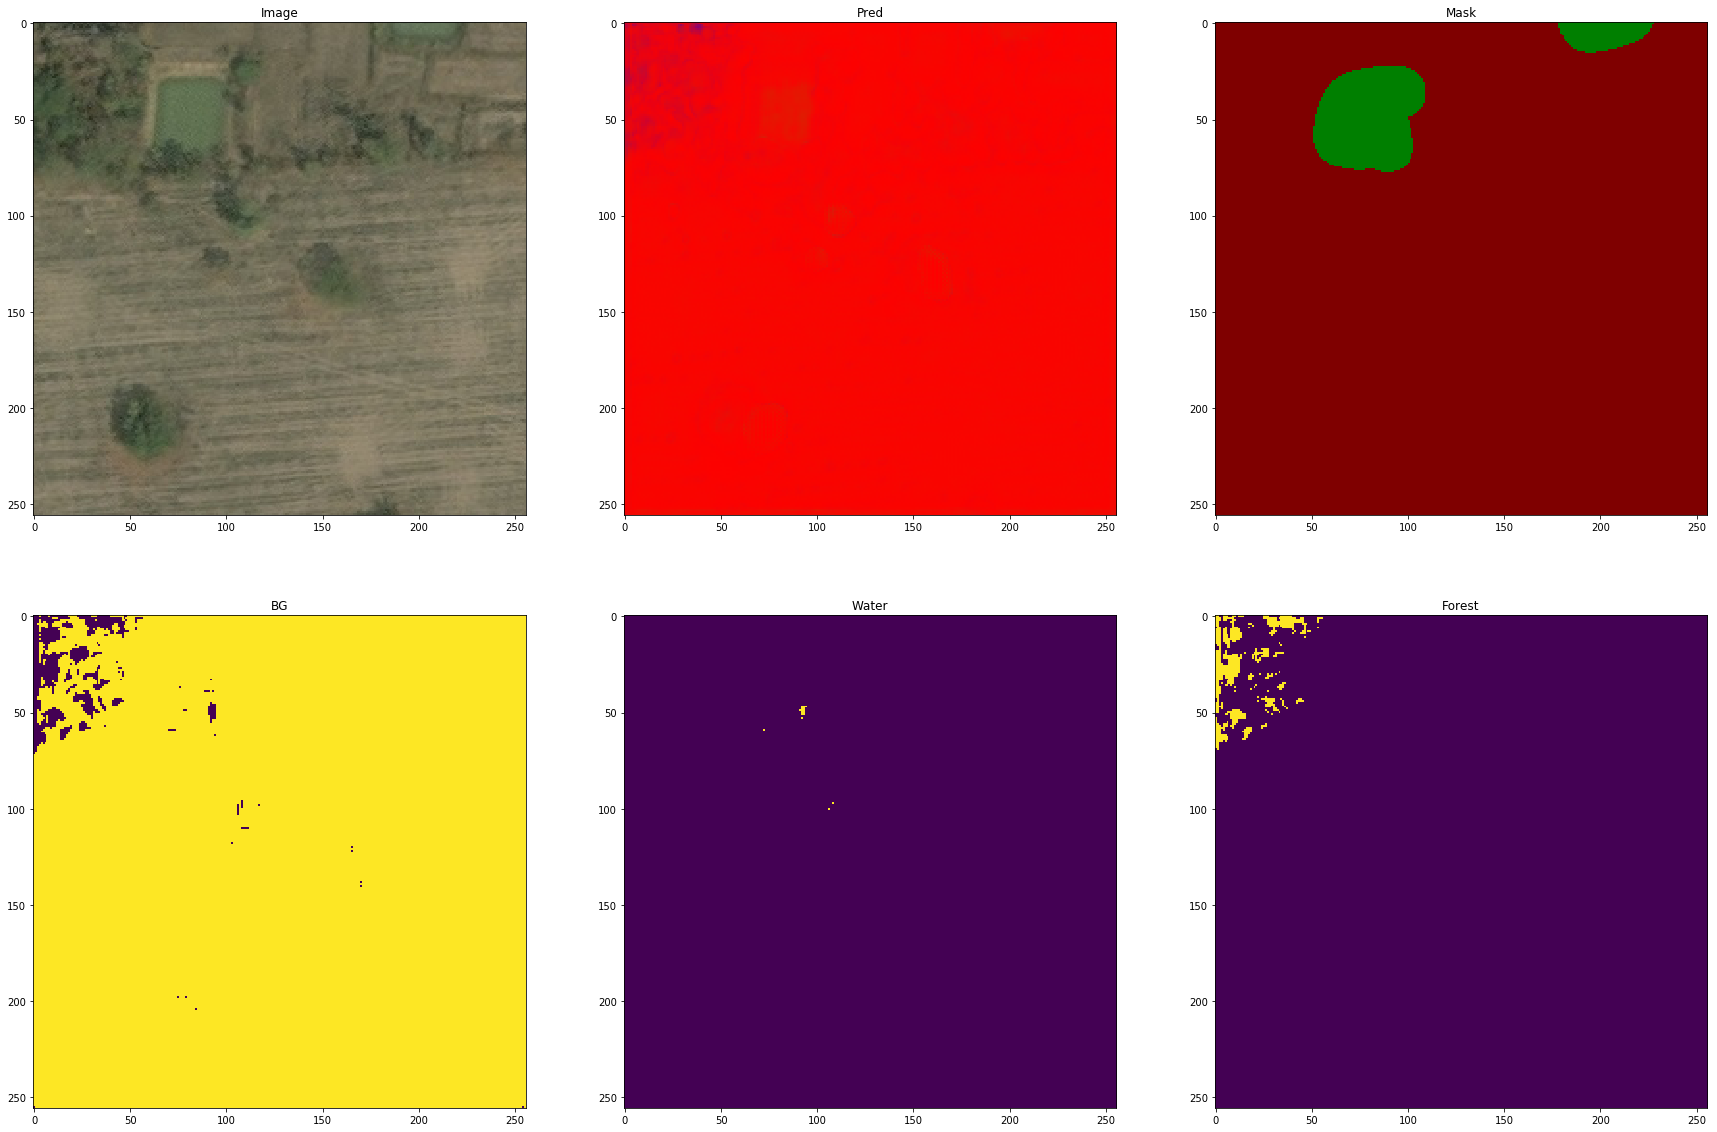

In [125]:
i = np.random.randint(len(masks))

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 20))
ax1.imshow(images[i])
ax1.set_title('Image')
ax2.imshow(y_pred[i])
ax2.set_title('Pred')
ax3.imshow(masks[i]*127)
ax3.set_title('Mask')
ax4.imshow(y_pred[i][:,:,0]>0.9)
ax4.set_title('BG')
ax5.imshow(y_pred[i][:,:,1]>0.1)
ax5.set_title('Water')
ax6.imshow(y_pred[i][:,:,2]>0.1)
ax6.set_title('Forest')

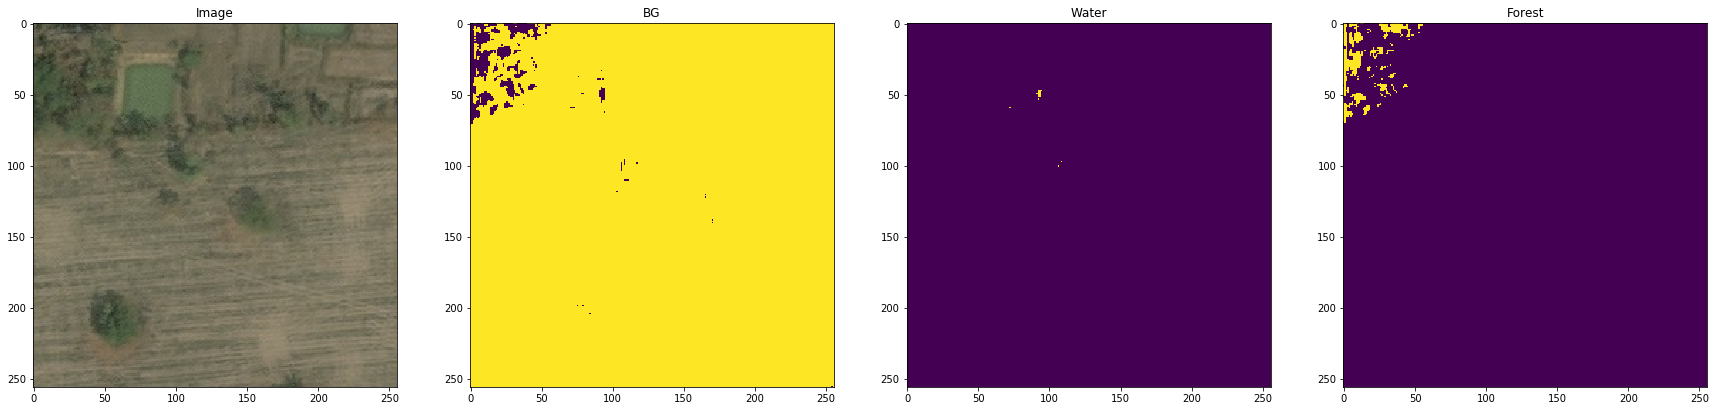

In [126]:
# i = np.random.randint(len(masks))

f, ((ax1, ax4, ax5, ax6)) = plt.subplots(1, 4, figsize=(30, 20))
ax1.imshow(images[i])
ax1.set_title('Image')
ax4.imshow(y_pred[i][:,:,0]>0.9)
ax4.set_title('BG')
ax5.imshow(y_pred[i][:,:,1]>0.1)
ax5.set_title('Water')
ax6.imshow(y_pred[i][:,:,2]>0.1)
ax6.set_title('Forest')
plt.savefig('aerial_sample_{}.png'.format(i))

# Критика модели

# Краткое резюме

# Предложения по улучшению

#TODO Тут будет наш размеченный ортофотоплан

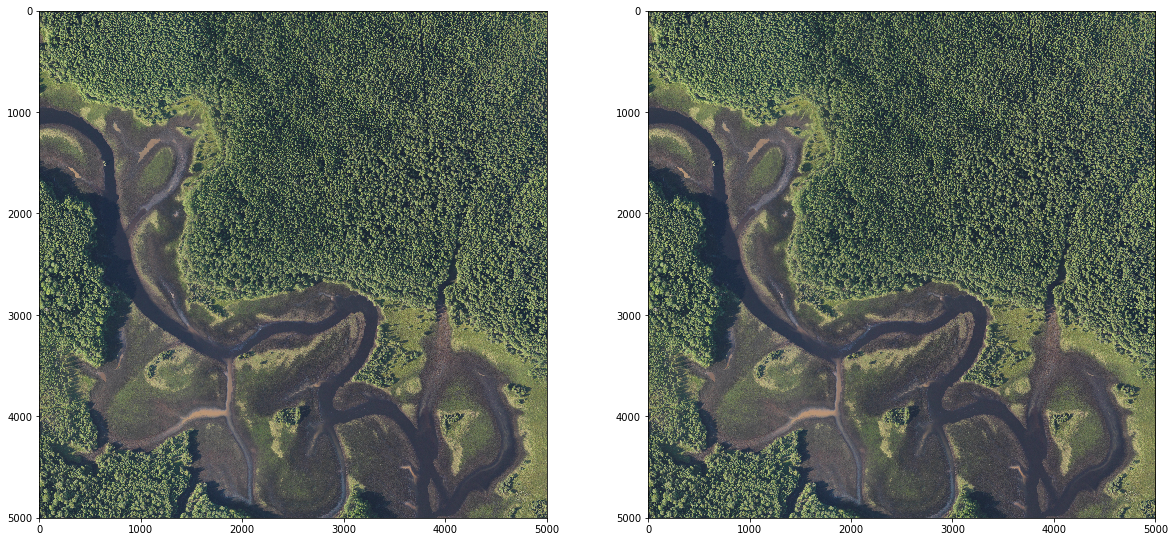

In [59]:
ind = FilesIndex(path='../ignore/example_tif/*.tif')
gpads = Dataset(ind, AerialBatch)

batch = (gpads.next_batch(1)
              .load(ind, fmt='image', components='images')
#               .load(ind, fmt='mask', components='masks')
        )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(batch.images[0])
ax2.imshow(batch.images[0])
plt.show()